In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [2]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float64, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  
obs = simulator.sample(1)

In [3]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
d_marker = 'd' if glob_det == 'det' else 's'
# s_marker = '_asymL2'
# m_marker = '_m1' # m0 - plain, m1 - learns binwise mu, m2 - learns theta 
# netid = p_marker+b_marker+d_marker+str(train_bounds)+s_marker+m_marker
netid = p_marker+b_marker+d_marker+str(train_bounds)

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

/tmp/ipykernel_307193/600084491.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


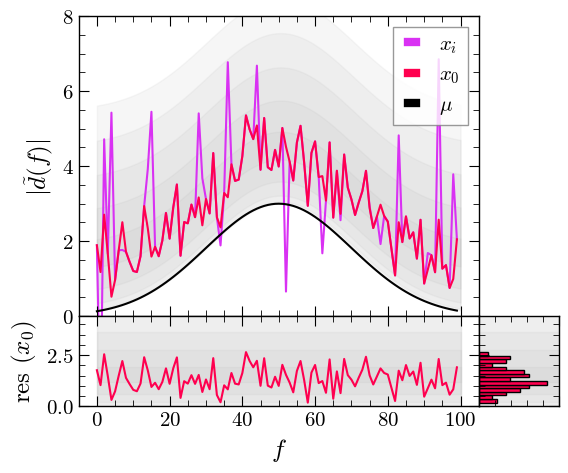

In [4]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

quantiles = np.array([5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()

In [ ]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_Mu(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0)

        self.mu_predictor = torch.nn.Sequential(
            torch.nn.Linear(Nbins, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, Nbins)
        )

    def mu(self, x):
        x = self.mu_predictor(x.unsqueeze(1)).squeeze(1)
        return x
    
    # def epsilon(self, x):
        # x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        # return x
    
    # def snr(self, x):
        # return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    # def forward(self, x):
        
    #     # Adaptive data generation
    #     ni = x['ni']
    #     epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
    #     data =  x['x0'] + epsilon_sim * ni
        
    #     # data = x['x']
    #     epsilon = self.epsilon(data)
    #     mask = ( x['ni'] != 0 )  
    #     squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
    #     l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
    #     return (l * mask.float()).sum() * 0.5

    def forward(self, x):

        # Data generation #

        # generate a noise block like x #
        x_shape = x['x0'].shape # [nsims,nbins]
        noise = torch.complex(torch.randn(x_shape).cuda(), torch.randn(x_shape).cuda()).cuda()
        norm_noise = torch.abs(noise)

        # generate a mu block like x #
        m, amp, sigma = [Nbins/2,3,20]
        grid = torch.arange(Nbins).cuda()
        mu = amp * torch.exp(-0.5 * ((grid - m) / sigma) ** 2)
        mu_block = (torch.ones(x_shape).cuda())*mu.unsqueeze(0)

        stoch_mu  = mu_block+norm_noise

        # gen net # 
        net_mu = self.mu(stoch_mu)

        # evaluate #
        error = (net_mu-mu)**2
        l = error / (self.logvariance.exp() + 1e-10) + self.logvariance 
        return l.sum() * 0.5
        

In [ ]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    # sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_mu = Network_Mu()
model = CustomLossModule_withBounds(network_mu, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_mu.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Network_epsilon | 108 K  | train
--------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.435     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
/opt/ioa/software/anaconda3/envs/python-3.11-2023-12

Training: |          | 0/? [00:00<?, ?it/s]

/opt/ioa/software/anaconda3/envs/python-3.11-2023-12a/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
torch.save(network_mu, f'networks/network_mu_{netid}_complex')
torch.save(model, f'networks/model_mu_{netid}_complex')

/tmp/ipykernel_307193/1346409765.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_cmap = cm.get_cmap('magma')
/tmp/ipykernel_307193/1346409765.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


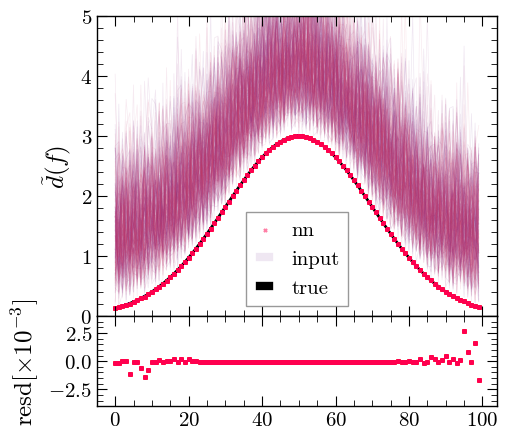

In [ ]:
from matplotlib import cm

number =200
magma_cmap = cm.get_cmap('magma')
colors = magma_cmap(np.linspace(0.3, 0.6, number))

fig, ax1 = pf.create_plot()
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)


obs = simulator.sample(number)

true = obs['x0'].cuda()
pred = network_mu.mu(true)

pred_cpu = pred.cpu().detach().numpy()

xvals = np.arange(100)

for i in range(number):
    ax1.scatter(xvals, pred_cpu[i], s=5,alpha=0.5,color='#ff004f', label=('nn' if i==0 else None), marker='x')
    resd = pred_cpu[i] - obs['mu'][0].numpy()
    ax2.scatter(xvals, resd*10*33, s=5,alpha=0.5,color='#ff004f', label='nn', marker='x')

    ax1.plot(xvals, obs['x0'][i], lw=0.5, alpha=0.1, zorder=-10, label=('input' if i==0 else None), color=colors[i])

ax1.plot(xvals, obs['mu'][0], label='true', color='black', lw=2, zorder=-1)
ax1.legend()

ax1.set_ylim([0,5])
ax1.set_ylabel(r'$\tilde{d}(f)$')
ax2.set_ylim([-4,4])
ax2.set_ylabel(r'resd$[\times 10^{-3}]$')

pf.fix_plot([ax1,ax2])
plt.tight_layout()

plt.savefig(f'figs/munet_predictor.png', dpi=700, bbox_inches = 'tight')


In [ ]:
# nsample = 2**11
# nmc = 2**21
# numruns = int(nmc/nsample)

# mu_all = []

# for i in tqdm(range(numruns)):
#     mu_all.append(network_mu.mu(simulator.sample(nsample)['x0'].cuda()).cpu())

# mu_all = torch.concatenate(mu_all).flatten()


In [63]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_Theta(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0)

        self.theta_predictor = torch.nn.Sequential(
            torch.nn.Linear(Nbins, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 3)
        )

    def mu(self, x):
        theta = self.theta_predictor(x.unsqueeze(1)).squeeze(1)
        grid = torch.arange(Nbins).cuda() * torch.ones_like(x)

        amp_mu = theta[:,0].unsqueeze(-1)
        mu_mu = theta[:,1].unsqueeze(-1)
        sigma_mu = theta[:,2].unsqueeze(-1)

        gauss = amp_mu * torch.exp(-0.5 * ((grid - mu_mu) / sigma_mu) ** 2)
        return gauss
    
    # def epsilon(self, x):
        # x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        # return x
    
    # def snr(self, x):
        # return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    # def forward(self, x):
        
    #     # Adaptive data generation
    #     ni = x['ni']
    #     epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
    #     data =  x['x0'] + epsilon_sim * ni
        
    #     # data = x['x']
    #     epsilon = self.epsilon(data)
    #     mask = ( x['ni'] != 0 )  
    #     squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
    #     l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
    #     return (l * mask.float()).sum() * 0.5

    def forward(self, x):

        # Data generation #

        # generate a noise block like x #
        x_shape = x['x0'].shape # [nsims,nbins]
        noise = torch.complex(torch.randn(x_shape).cuda(), torch.randn(x_shape).cuda()).cuda()
        norm_noise = torch.abs(noise)

        # generate a mu block like x #
        m, amp, sigma = [Nbins/2,3,20]
        grid = torch.arange(Nbins).cuda()
        mu = amp * torch.exp(-0.5 * ((grid - m) / sigma) ** 2)
        mu_block = (torch.ones(x_shape).cuda())*mu.unsqueeze(0)

        stoch_mu  = mu_block+norm_noise

        # gen net # 
        net_mu = self.mu(stoch_mu)

        # evaluate #
        error = (net_mu-mu)**2
        l = error / (self.logvariance.exp() + 1e-10) + self.logvariance 
        return l.sum() * 0.5
        

In [64]:
batch_size = 128
samples = simulator.sample(Nsims=Nsims)  

dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=31)
network_theta = Network_Theta()
model = CustomLossModule_withBounds(network_theta, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_theta.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | Network_Theta | 96.4 K | train
------------------------------------------------
96.4 K    Trainable params
0         Non-trainable params
96.4 K    Total params
0.385     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 23.49 GiB of which 4.31 MiB is free. Process 213197 has 5.17 GiB memory in use. Including non-PyTorch memory, this process has 17.90 GiB memory in use. Of the allocated memory 34.82 MiB is allocated by PyTorch, and 5.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
a = torch.tensor([1,1,1])
a.unsqueeze(0).shape

torch.Size([1, 3])